## Нач значения


In [174]:
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from numba import jit, njit, prange
import csv
from tqdm import tqdm
import pandas as pd


# Физические константы
class Constants:
    G = 6.67e-11  # гравитационная постоянная
    M1 = 2.0e30   # масса звезды (кг)
    M2 = 5.7e26   # масса планеты (кг)
    M3 = 1.4e23   # масса спутника (кг)
    R1 = 696340e3 # радиус звезды (м)
    R2 = 60270e3   # радиус планеты (м)
    R3 = 2575e3   # радиус спутника (м)
    R12 = 1429e9   # начальное расстояние звезда-планета (м)
    R23 = 1222e6   # начальное расстояние планета-спутника (м)
    U2 = 9.7e3     # начальная скорость планеты (м/с)
    U3 = 5.57e3   # начальная скорость спутника (м/с)
    T = 4100.0    # время работы двигателя (с)
    H = 1000e3     # высота орбиты (м)
    M0 = 95.0     # масса полезной нагрузки (кг)
    U = 2500.0    # скорость истечения (м/с)
    koef = 0.001

In [125]:
@njit
def distance(x1, y1, x2, y2):
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

@njit
def calculate_forces(t, y):
    r12x, r12y, r13x, r13y = y[0], y[1], y[2], y[3]
    v2x, v2y, v3x, v3y = y[4], y[5], y[6], y[7]

    # Расчёт расстояний
    r12 = np.sqrt(r12x ** 2 + r12y ** 2)      # расстояние от планеты до солнца
    r13 = np.sqrt(r13x ** 2 + r13y ** 2)     # расстояние от спутника до солнца
    r23 = distance(r13x, r13y, r12x, r12y)   # расстояние от спутника до планеты

    # Ускорения для спутника
    f3x = (
        - Constants.G * Constants.M1 * r13x / r13  ** 3
           - Constants.G * Constants.M2 * (r13x - r12x) / r23 ** 3)
    f3y = (
        - Constants.G * Constants.M1 * r13y / r13 ** 3
        - Constants.G * Constants.M2 * (r13y - r12y) / r23 ** 3)

    # Ускорение для планеты
    f2x = (- Constants.G * Constants.M1 * r12x/ r12 ** 3
           + Constants.G * Constants.M3 *  (r13x - r12x) / r23 ** 3)

    f2y = (- Constants.G * Constants.M1 * r12y/ r12 ** 3
           + Constants.G * Constants.M3 *  (r13y - r12y) / r23 ** 3)

    return [v2x, v2y, v3x, v3y, f2x, f2y , f3x, f3y ]

In [38]:
# положение планеты в начальный момент времени
r12x0 = Constants.R1 + Constants.R12 + Constants.R2
r12y0 = 0
v2x0 = 0
v2y0 = Constants.U2

# положение спутника  в начальный момент времени
r13x0 = Constants.R1 + Constants.R12 + Constants.R2 * 2 + Constants.R23 + Constants.R3
r13y0 = 0
v3x0 = 0
v3y0 = Constants.U2 + Constants.U3

mt = 0
y0 = [r12x0, r12y0, r13x0, r13y0,  v2x0, v2y0, v3x0, v3y0]

t0 = 0.0
t_end = int(60 * 60 * 24 * 10759 )
t_span = (0, t_end)

dt = 40000
t_eval = np.arange(0, t_end, dt)


sol = integrate.solve_ivp(
    calculate_forces,
    (t0, t_end),
    y0,
    method='DOP853',
    t_eval=t_eval,
    rtol=1e-5,
    atol=1e-5,
    vectorized=True
)

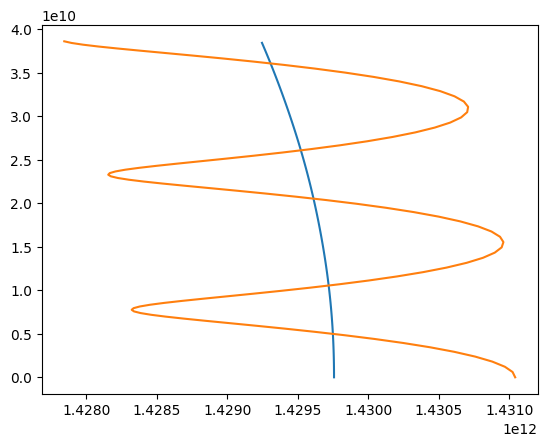

In [40]:
solution = sol.y[:,:100]

plt.plot(solution[0],solution[1])
plt.plot(solution[2],solution[3])

## Нач положение корабля

In [41]:
r12y0, r12x0 = 0 , Constants.R1 + Constants.R12 + Constants.R2
v2x0, v2y0 = 0, Constants.U2
r13y0, r13x0 = 0, Constants.R1 + Constants.R12 + Constants.R2 * 2 + Constants.R23 + Constants.R3
v3x0, v3y0 = 0, Constants.U2 + Constants.U3
r12x,r12y= r12x0,r12y0

In [138]:
# Вспомогательные функции

def m(t, mt) -> np.float64:
    if t >= Constants.T:
        return Constants.M0
    else:
        return (Constants.M0 + mt) / (1 - Constants.koef) - (mt * t) / Constants.T

def dm(t, mt) -> np.float64:
    if t > Constants.T:
        return 0.0
    else:
        return -mt / Constants.T
@njit
def distance(x1, y1, x2, y2) -> np.float64:
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def calculate_forces(t, y, mt):
    rx, ry, r13x, r13y = y[0], y[1], y[2], y[3]
    vx, vy, v3x, v3y = y[4], y[5], y[6], y[7]
    r12x, r12y, v2x, v2y=r12x0, r12y0, y[10], y[11]

    # Расчёт расстояний
    r = np.sqrt(rx ** 2 + ry ** 2)           # расстояние от солнца до ракеты
    r2 = distance(rx, ry, r12x, r12y)        # расстояние от ракеты до планеты
    r3 = distance(rx, ry, r13x, r13y)        # расстояние от ракеты до спутника
    r12 =np.sqrt(r12x ** 2 + r12y ** 2)
    r13 = np.sqrt(r13x ** 2 + r13y ** 2)     # расстояние от спутника до солнца
    r23 = distance(r13x, r13y, r12x, r12y)   # расстояние от спутника до планеты

    v = np.sqrt(vx ** 2 + vy ** 2)
    f_rocket_x = -(Constants.U * dm(t, mt) * vx) / (v * m(t, mt))
    f_rocket_y = -(Constants.U * dm(t, mt) * vy) / (v * m(t, mt))

    f_gravity_x = Constants.G * (
        - Constants.M1 * rx / r ** 3
        - Constants.M2 * (rx - r12x) / r2 ** 3 - Constants.M3 * (rx - r13x) / r3 ** 3)
    f_gravity_y = Constants.G * (
        - Constants.M1 * ry / r ** 3
        - Constants.M2 * (ry - r12y) / r2 ** 3 - Constants.M3 * (ry - r13y) / r3 ** 3)

    # Ускорения для ракеты
    fx = f_rocket_x + f_gravity_x
    fy = f_rocket_y + f_gravity_y

    # Ускорения для спутника
    f3x = (
        - Constants.G * Constants.M1 * r13x / r13  ** 3
           - Constants.G * Constants.M2 * (r13x - r12x) / r23 ** 3)
    f3y = (
        - Constants.G * Constants.M1 * r13y / r13 ** 3
        - Constants.G * Constants.M2 * (r13y - r12y) / r23 ** 3)

    # Ускорение для планеты
    f2x = (- Constants.G * Constants.M1 * r12x/ r12 ** 3
           + Constants.G * Constants.M3 *  (r13x - r12x) / r23 ** 3)

    f2y = (- Constants.G * Constants.M1 * r12y/ r12 ** 3
           + Constants.G * Constants.M3 *  (r13y - r12y) / r23 ** 3)

    return np.array([vx, vy, v3x, v3y, fx, fy, f3x, f3y, v2x, v2y, f2x, f2y],dtype=np.float64)

In [147]:
def collision_event(t, y, mt):
    rx, ry, r3x, r3y, _, _, _, _, _, _, _, _= y
    distance = np.sqrt((rx - r3x)**2 + (ry - r3y)**2)
    return distance - Constants.R3
# collision_event.terminal = True

In [140]:
def integrate_trajectory(angle, mt, output=False):
    _angle = np.radians(angle)  # угол в радианах

    v3x = v3x0 - v2x0
    v3y = v3y0 - v2y0

    r12x = r12x0
    r12y = r12y0

    r3x = r13x0 - r12x
    r3y = r13y0 - r12y
    r3 = np.sqrt(r3x ** 2 + r3y ** 2)

    v0 = np.sqrt(Constants.G * Constants.M2 / (Constants.R2 + Constants.H))
    rx0 = (Constants.R2 + Constants.H) * (r3x * np.cos(_angle) - r3y * np.sin(_angle)) / r3
    ry0 = (Constants.R2 + Constants.H) * (r3x * np.sin(_angle) + r3y * np.cos(_angle)) / r3

    r0 = np.sqrt(rx0 ** 2 + ry0 ** 2)

    vx0 = -v0 * ry0 / r0
    vy0 = v0 * rx0 / r0

    rx0 += r12x0
    ry0 += r12y0

    y0 = [rx0, ry0, r13x0, r13y0, vx0, vy0, v3x, v3y,r12x0,r12y0,v2x0,v2y0]

    t0 = 0.0
    t_end = int(60 * 60 * 24 * 19 * 1)
    t_span = (0, t_end)
    t_eval = np.linspace(0, t_end, t_end // 2 )

    sol = integrate.solve_ivp(
      calculate_forces,
      t_span,
      y0,
      method='RK45',
      t_eval=t_eval,
      rtol=1e-12,
      atol=1e-12,
      events=collision_event,  # закоментировать для оптимизации
      args = (mt,)
  )

    if output:
        np.savetxt(f'trajectory_mt-{mt}_angle-{angle}.csv', np.column_stack([sol.y[0], sol.y[1], sol.y[2], sol.y[3]]), delimiter=" ", header="x y x3 y3", comments="")

    return sol

In [165]:
_mt = 5350
angle = 0

solution = integrate_trajectory(angle, _mt, output=False)

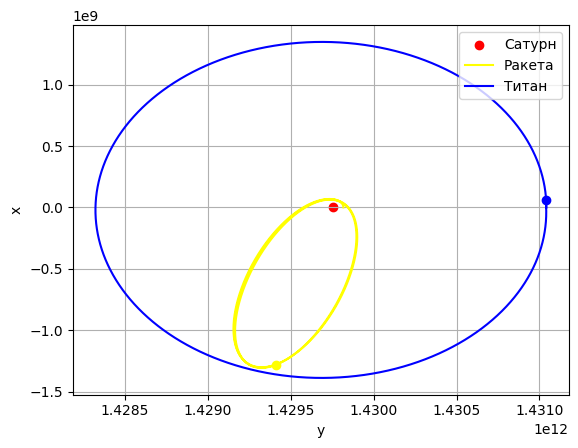

In [166]:
sol = solution.y
plt.scatter(r12x,r12y,label='Сатурн',color='red')
plt.plot(sol[0],sol[1], label='Ракета',color='yellow')
plt.plot(sol[2],sol[3], label='Титан',color='blue')
plt.scatter(sol[2][-1],sol[3][-1],color='blue')
plt.scatter(sol[0][-1],sol[1][-1],color='yellow')


plt.xlabel('y')
plt.ylabel('x')
plt.legend(loc='best')
plt.grid()
plt.show()

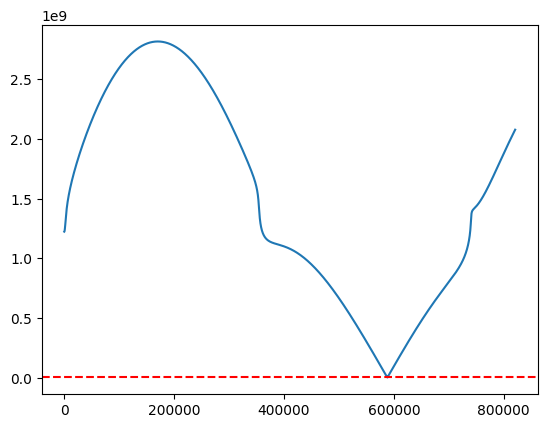

In [157]:
plt.plot(distance(sol[0],sol[1],sol[2],sol[3]))
plt.axhline(y = Constants.R3,color='r', linestyle='--' )
# plt.ylim(0,5e7)

In [158]:
def save_to_csv(data, filename):
    with open(filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Angle", "MT"])
        writer.writerows(data)

In [181]:
MT_MIN = []
for _angle in range(10, 360):
    for _mt in tqdm(np.arange(5400,5650, 1), desc=f"Angle {_angle}"):
        solution = integrate_trajectory(_angle, _mt, output=False)
        if solution.t_events[0].size > 0:
            print(f'boom: {_mt}', end='\r')
            MT_MIN.append((_angle,_mt))
            break

Angle 10:  53%|█████▎    | 132/250 [01:29<01:20,  1.47it/s]


Angle 11:  54%|█████▍    | 135/250 [01:20<01:08,  1.67it/s]


Angle 12:  55%|█████▌    | 138/250 [01:25<01:09,  1.62it/s]


Angle 13:  57%|█████▋    | 142/250 [01:35<01:12,  1.48it/s]


Angle 14:  58%|█████▊    | 145/250 [01:36<01:09,  1.50it/s]


Angle 15:  59%|█████▉    | 148/250 [01:37<01:07,  1.52it/s]


Angle 16:  60%|██████    | 151/250 [01:38<01:04,  1.53it/s]


Angle 17:  62%|██████▏   | 155/250 [01:49<01:07,  1.41it/s]


Angle 18:  63%|██████▎   | 158/250 [01:53<01:06,  1.39it/s]


Angle 19:  64%|██████▍   | 161/250 [01:49<01:00,  1.47it/s]


Angle 20:  66%|██████▌   | 164/250 [01:45<00:55,  1.56it/s]


Angle 21:  67%|██████▋   | 167/250 [01:50<00:54,  1.51it/s]


Angle 22:  68%|██████▊   | 171/250 [01:47<00:49,  1.59it/s]


Angle 23:  70%|██████▉   | 174/250 [01:58<00:51,  1.47it/s]


Angle 24:  71%|███████   | 177/250 [02:05<00:51,  1.41it/s]


Angle 25:  72%|███████▏  | 180/250 [02:02<00:47,  1.47it/s]


Angle 26:  73%|███████▎  | 183/250 [02:04<00:45,  1.47it/s]


Angle 27:  75%|███████▍  | 187/250 [02:05<00:42,  1.50it/s]


Angle 28:  76%|███████▌  | 190/250 [02:07<00:40,  1.50it/s]


Angle 29:  77%|███████▋  | 193/250 [02:06<00:37,  1.52it/s]


Angle 30:  38%|███▊      | 95/250 [01:09<01:52,  1.38it/s]


KeyboardInterrupt: 

In [182]:
save_to_csv(MT_MIN,'result_new.csv')

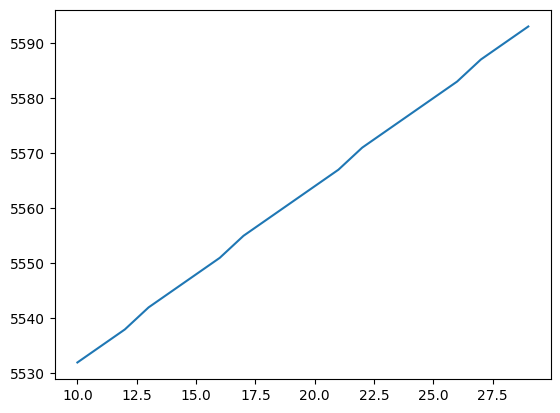

In [183]:
data=pd.read_csv('result_new.csv',sep=',')
plt.plot(data.Angle,data.MT)